# AH2179 Applied Artificial Intelligence in Transportation Group 5 Project
### By Fabian Fermazin, William Öman, Itsuki Shindo

In [80]:
#pip install calmap

In [81]:
import pandas as pd
import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import calmap
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Data Preparation

In [82]:
df = pd.read_csv('Dataset-PT_seasons.csv')
Stockholmtemp2022 = pd.read_csv('Stockholmtemp2022.csv', sep=';')

In [83]:
# Change the date format of Stockholmtemp2022 to match the df
def change_date_format(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime("%Y%m%d")
Stockholmtemp2022["date"] = Stockholmtemp2022["date"].apply(change_date_format)

# Change the name of the date column to match the df
Stockholmtemp2022["Calendar_date"] = 0
Stockholmtemp2022["Calendar_date"] = Stockholmtemp2022["date"]
Stockholmtemp2022.drop(columns=["date"])

,temp,Calendar_date
0,-1.4,20220101
1,1.9,20220102
2,3.6,20220103
3,0.6,20220104
4,-2.2,20220105
...,...,...
176,23.1,20220626
177,24.1,20220627
178,24.1,20220628
179,19.6,20220629


In [84]:
# Merge df and Stockholmtemp2022
Stockholmtemp2022["Calendar_date"] = Stockholmtemp2022["Calendar_date"].astype(int)
df = pd.merge(df, Stockholmtemp2022, on='Calendar_date')
df = df.drop(columns=['date'])
df["Calendar_date"] = pd.to_datetime(df['Calendar_date'], format='%Y%m%d')

# Data Exploration

In [85]:
days = np.unique(df[['Calendar_date']].values.ravel())

Calendar_date
2022-05-20    3969
2022-04-06    3969
2022-02-17    3969
2022-05-16    3969
2022-01-18    3969
              ... 
2022-05-30     108
2022-05-31      81
2022-06-01      81
2022-06-02      81
2022-06-03      81
Length: 173, dtype: int64

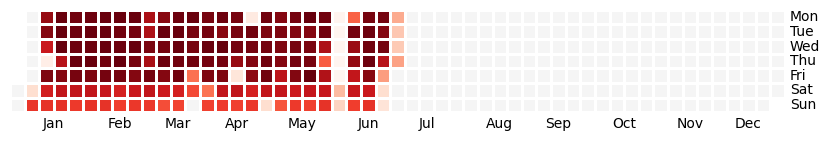

In [86]:
#higher frequency = more buses (or data measurements) that day
df['Calendar_date'] = pd.to_datetime(df['Calendar_date'])
date_freq = df.value_counts('Calendar_date')
plt.figure(figsize=(10,5))
calmap.yearplot(date_freq, year = 2022)
date_freq

In [87]:
snow_by_day = df.groupby(df['Calendar_date'].dt.date)['factor(weather)Snow'].sum() > 0
days_with_snow = snow_by_day[snow_by_day].index
print("Days with snow:")
for day in days_with_snow:
    print(day)

Days with snow:
2022-02-08
2022-02-19
2022-02-21
2022-03-29
2022-04-01
2022-04-05
2022-04-07
2022-04-08
2022-04-09


In [88]:
lightsnow_by_day = df.groupby(df['Calendar_date'].dt.date)['factor(weather)Light_Snow'].sum() > 0
days_with_lightsnow = lightsnow_by_day[lightsnow_by_day].index
print("Days with light snow:")
for day in days_with_lightsnow:
    print(day)

Days with light snow:
2022-01-08
2022-01-17
2022-01-29
2022-01-30
2022-02-01
2022-02-02
2022-02-08
2022-02-17
2022-02-19
2022-02-21
2022-02-23
2022-03-31
2022-04-01
2022-04-04
2022-04-07
2022-04-08
2022-04-09


In [89]:
rain_by_day = df.groupby(df['Calendar_date'].dt.date)['factor(weather)Rain'].sum() > 0
days_with_rain = rain_by_day[rain_by_day].index
print("Days with rain:")
for day in days_with_rain:
    print(day)

Days with rain:
2022-01-29
2022-02-16
2022-04-07
2022-05-07
2022-05-11
2022-05-14
2022-05-20
2022-05-27
2022-05-28


In [90]:
extracold_by_day = df.groupby(df['Calendar_date'].dt.date)['factor(temperature)Extra_cold'].sum() > 0
days_with_extracold = extracold_by_day[extracold_by_day].index
print("Extra cold days:")
for day in days_with_extracold:
    print(day)


Extra cold days:
2022-01-22
2022-01-25
2022-02-01
2022-02-02
2022-02-22
2022-02-23
2022-03-04
2022-03-05
2022-03-09
2022-03-12
2022-03-13
2022-03-14
2022-03-16
2022-03-29
2022-03-31
2022-04-01
2022-04-02


In [91]:
#We will remove this trip as an outlier since it is one hour early
df_new = df[(df['Calendar_date'] != '2022-06-30') | (df['bus_id']!=41361)]
#df_new.to_csv('clean_dataPT.csv')

In [92]:
#assign a trip id per trip, since bus id repeats itself within a day sometimes
df_new['trip_id'] = df_new.index // 27 + 1
df_new['trip_id']

<ipython-input-92-6b86ea210639>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['trip_id'] = df_new.index // 27 + 1


0             1
1             1
2             1
3             1
4             1
          ...  
545098    20189
545099    20189
545100    20189
545101    20189
545102    20189
Name: trip_id, Length: 545076, dtype: int64

In [93]:
#check if the above worked how we want it
df_new.groupby(['Calendar_date','bus_id','stop_sequence','trip_id'])['dwell_time'].count().sort_values()

Calendar_date  bus_id  stop_sequence  trip_id
2022-01-08     41344   1              1          1
2022-04-26     45533   1              13352      1
               45532   27             13470      1
                                      13452      1
                                      13429      1
                                                ..
2022-03-02     41727   21             6714       1
                                      6697       1
                                      6676       1
                       22             6783       1
2022-06-30     45722   27             20149      1
Name: dwell_time, Length: 545076, dtype: int64

In [94]:
#remove irrelevant columns. temperature related columns deemed irrelavant because we imported numeric temp data
df_new = df_new.drop(['route_id','temperature','factor(temperature)Cold','factor(temperature)Extra_cold','factor(temperature)Normal'], axis = 1)

In [95]:
df_new

,Calendar_date,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,...,factor(weather)Rain,factor(weather)Snow,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,Season,temp,trip_id
0,2022-01-08,41344,1,151,0,0,120,100,100,160,...,0,0,0,1,0,0,1,Winter,-0.5,1
1,2022-01-08,41344,2,185,24,171,45,151,100,198,...,0,0,0,1,0,0,1,Winter,-0.5,1
2,2022-01-08,41344,3,186,0,55,41,185,100,189,...,0,0,0,1,0,0,1,Winter,-0.5,1
3,2022-01-08,41344,4,202,12,42,94,186,100,200,...,0,0,0,1,0,0,1,Winter,-0.5,1
4,2022-01-08,41344,5,242,21,98,86,202,100,256,...,0,0,0,1,0,0,1,Winter,-0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,2022-06-30,41362,23,344,13,74,44,341,12,47,...,0,0,1,0,0,0,1,Summer,22.4,20189
545099,2022-06-30,41362,24,330,15,34,92,344,12,68,...,0,0,1,0,0,0,1,Summer,22.4,20189
545100,2022-06-30,41362,25,339,17,63,43,330,12,69,...,0,0,1,0,0,0,1,Summer,22.4,20189
545101,2022-06-30,41362,26,331,0,35,58,339,12,79,...,0,0,1,0,0,0,1,Summer,22.4,20189


In [96]:
#df_new.to_csv('clean_dataPT2.csv')

#Clustering

In [97]:
data = pd.read_csv('clean_dataPT2.csv')

In [121]:
df_test = data.groupby(['stop_sequence','Calendar_date'])[['arrival_delay', 'dwell_time', 'traffic_condition', 'recurrent_delay', 'origin_delay', 'previous_bus_delay', 'factor(day_of_week)weekday', 'factor(time_of_day)Off-peak', 'temp','scheduled_travel_time']].mean()


In [99]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

In [163]:
%matplotlib inline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler


In [164]:
scaling=StandardScaler()

# Use fit and transform method
scaling.fit(df_test)
Scaled_data=scaling.transform(df_test)

# Set the n_components=3
principal=KernelPCA(n_components=2, kernel = 'rbf')
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)

# Check the dimensions of data after PCA
print(x.shape)

(4671, 2)


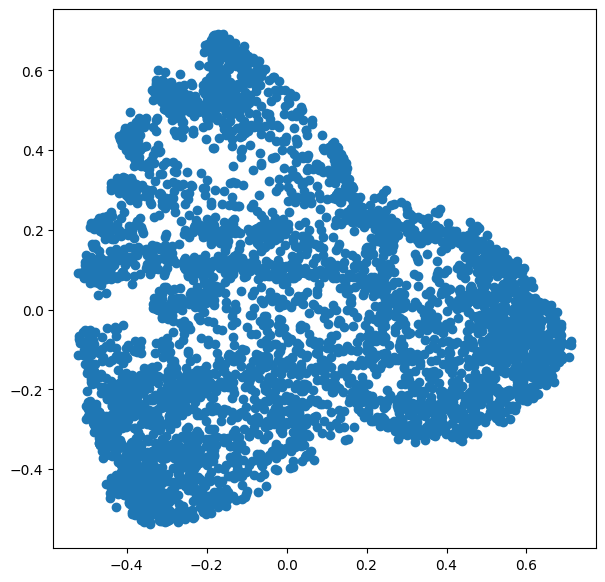

In [165]:
plt.figure(figsize=(7,7))
#plt.xlim(-4,4)
#plt.ylim(-2.5,5)
plt.scatter(x[:,0],x[:,1])

In [103]:

"""clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(data)

cluster_labels = GaussianMixture(n_components=n_clusters).fit(df_new).predict(data)"""

"clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(data)\n\ncluster_labels = GaussianMixture(n_components=n_clusters).fit(df_new).predict(data)"

In [174]:
# BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
#clusters = KMeans(n_clusters=5, random_state=0, n_init="auto")# check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#clusters.fit(x)

n_clusters = 16

clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(x) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
#clusters = DBSCAN(eps=500, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

if clusters is not None:
 cluster_labels = clusters.labels_

cluster_labels = GaussianMixture(n_components=n_clusters).fit(x).predict(x) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


print(cluster_labels)

[15 15 10 ...  6  6  6]


In [175]:
new_x = np.zeros([len(x), 3])
for i in range(0, len(x)):
    new_x[i] = (np.append(x[i], (cluster_labels[i])))

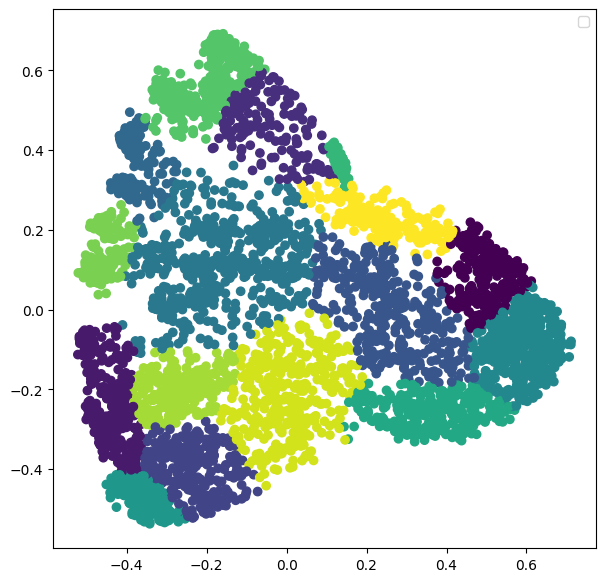

In [176]:
plt.figure(figsize=(7,7))
plt.scatter(new_x[:,0],new_x[:,1], c=new_x[:,2])
plt.legend()

In [172]:

# Define a list of n_clusters values to iterate over
n_clusters_values = list(range(2,21))

# Initialize lists to store scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Initialize variables to keep track of best and worst scores
best_silhouette_score = float('-inf')
worst_silhouette_score = float('inf')
best_davies_bouldin_score = float('inf')
worst_davies_bouldin_score = float('-inf')
best_calinski_harabasz_score = float('-inf')
worst_calinski_harabasz_score = float('inf')
best_silhouette_n_clusters = None
worst_silhouette_n_clusters = None
best_davies_bouldin_n_clusters = None
worst_davies_bouldin_n_clusters = None
best_calinski_harabasz_n_clusters = None
worst_calinski_harabasz_n_clusters = None

# Loop over different values of n_clusters
for n_clusters in n_clusters_values:
    # Fit K-Means clustering with the current number of clusters
    clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(x)
    cluster_labels = clusters.labels_

    # Calculate cluster quality scores
    SC_score = silhouette_score(x, cluster_labels)
    DB_score = davies_bouldin_score(x, cluster_labels)
    CH_score = calinski_harabasz_score(x, cluster_labels)

    # Update best and worst scores and their corresponding n_clusters values
    if SC_score > best_silhouette_score:
        best_silhouette_score = SC_score
        best_silhouette_n_clusters = n_clusters

    if DB_score < best_davies_bouldin_score:
        best_davies_bouldin_score = DB_score
        best_davies_bouldin_n_clusters = n_clusters

    if CH_score > best_calinski_harabasz_score:
        best_calinski_harabasz_score = CH_score
        best_calinski_harabasz_n_clusters = n_clusters


    # Append scores to the respective lists
    silhouette_scores.append(SC_score)
    davies_bouldin_scores.append(DB_score)
    calinski_harabasz_scores.append(CH_score)

# Create a DataFrame to store the scores
scores_df = pd.DataFrame({
    'n_clusters': n_clusters_values,
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Score': davies_bouldin_scores,
    'Calinski-Harabasz Score': calinski_harabasz_scores
})

# Highlight the rows with the best and worst scores
scores_df['Highlight'] = ''
scores_df.loc[scores_df['n_clusters'] == best_silhouette_n_clusters, 'Highlight'] = 'Best Silhouette'
scores_df.loc[scores_df['n_clusters'] == best_davies_bouldin_n_clusters, 'Highlight'] = 'Best Davies-Bouldin'
scores_df.loc[scores_df['n_clusters'] == best_calinski_harabasz_n_clusters, 'Highlight'] = 'Best Calinski-Harabasz'

# Display the scores table with highlights
print(scores_df)


    n_clusters  Silhouette Score  Davies-Bouldin Score  \
0            2          0.407489              0.866270   
1            3          0.498877              0.718989   
2            4          0.457267              0.906598   
3            5          0.425436              0.750360   
4            6          0.401707              0.789346   
5            7          0.369882              0.897579   
6            8          0.378658              0.830531   
7            9          0.369061              0.838524   
8           10          0.381649              0.820413   
9           11          0.367335              0.857484   
10          12          0.370236              0.853644   
11          13          0.369900              0.824522   
12          14          0.375161              0.805678   
13          15          0.376276              0.810443   
14          16          0.374244              0.829975   
15          17          0.360275              0.850840   
16          18

In [173]:
scores_df.to_csv('aggl_scores_stop_calKernel.csv')

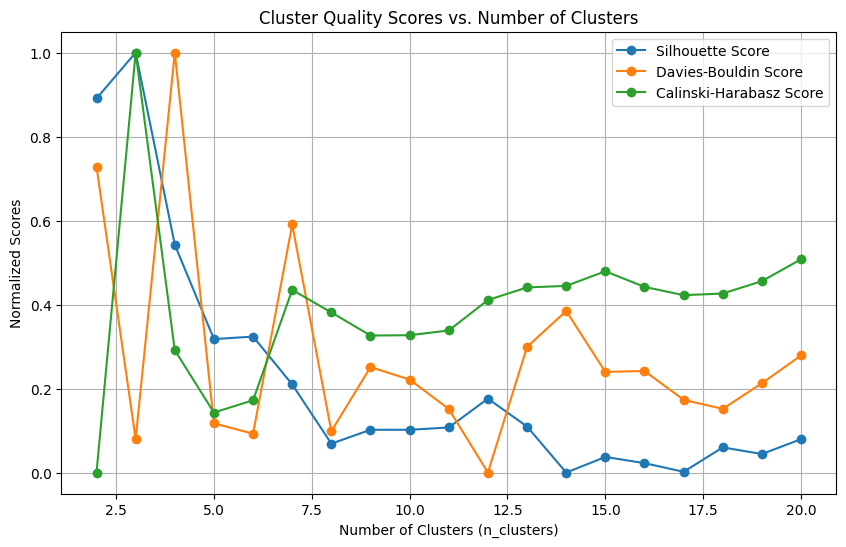

In [136]:
# Define a list of n_clusters values to iterate over
n_clusters_values = list(range(2,21))

# Initialize lists to store scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Loop over different values of n_clusters
for n_clusters in n_clusters_values:
    # Fit K-Means clustering with the current number of clusters
    clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(x)
    cluster_labels = clusters.labels_

    # Calculate cluster quality scores
    SC_score = silhouette_score(x, cluster_labels)
    DB_score = davies_bouldin_score(x, cluster_labels)
    CH_score = calinski_harabasz_score(x, cluster_labels)

    # Append scores to the respective lists
    silhouette_scores.append(SC_score)
    davies_bouldin_scores.append(DB_score)
    calinski_harabasz_scores.append(CH_score)

# Normalize the scores between 0 and 1 (optional)
scaler = MinMaxScaler()
silhouette_scores_normalized = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1))
davies_bouldin_scores_normalized = scaler.fit_transform(np.array(davies_bouldin_scores).reshape(-1, 1))
calinski_harabasz_scores_normalized = scaler.fit_transform(np.array(calinski_harabasz_scores).reshape(-1, 1))

# Create a DataFrame to store the normalized scores
normalized_scores_df = pd.DataFrame({
    'n_clusters': n_clusters_values,
    'Silhouette Score': silhouette_scores_normalized.flatten(),
    'Davies-Bouldin Score': davies_bouldin_scores_normalized.flatten(),
    'Calinski-Harabasz Score': calinski_harabasz_scores_normalized.flatten()
})

# Plot the scores for each n_clusters value
plt.figure(figsize=(10, 6))
plt.plot(normalized_scores_df['n_clusters'], normalized_scores_df['Silhouette Score'], label='Silhouette Score', marker='o')
plt.plot(normalized_scores_df['n_clusters'], normalized_scores_df['Davies-Bouldin Score'], label='Davies-Bouldin Score', marker='o')
plt.plot(normalized_scores_df['n_clusters'], normalized_scores_df['Calinski-Harabasz Score'], label='Calinski-Harabasz Score', marker='o')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Normalized Scores')
plt.title('Cluster Quality Scores vs. Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

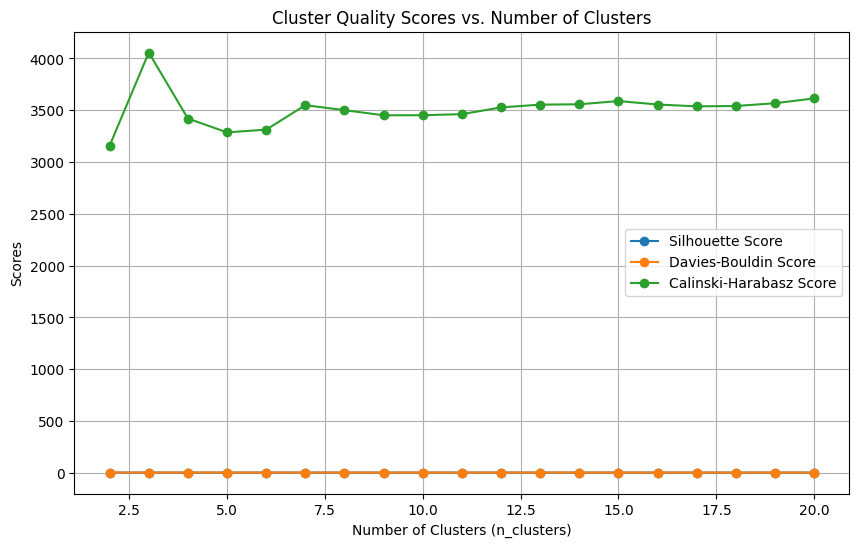

In [128]:
# Define a list of n_clusters values to iterate over
n_clusters_values = list(range(2,21))

# Initialize lists to store scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Loop over different values of n_clusters
for n_clusters in n_clusters_values:
    # Fit K-Means clustering with the current number of clusters
    clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(x)
    cluster_labels = clusters.labels_

    # Calculate cluster quality scores
    SC_score = silhouette_score(x, cluster_labels)
    DB_score = davies_bouldin_score(x, cluster_labels)
    CH_score = calinski_harabasz_score(x, cluster_labels)

    # Append scores to the respective lists
    silhouette_scores.append(SC_score)
    davies_bouldin_scores.append(DB_score)
    calinski_harabasz_scores.append(CH_score)

   # silhouette = list(map(float, items))
# Normalize the scores between 0 and 1 (optional)
"""scaler = MinMaxScaler()
silhouette_scores_normalized = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1))
davies_bouldin_scores_normalized = scaler.fit_transform(np.array(davies_bouldin_scores).reshape(-1, 1))
calinski_harabasz_scores_normalized = scaler.fit_transform(np.array(calinski_harabasz_scores).reshape(-1, 1))

# Create a DataFrame to store the normalized scores
normalized_scores_df = pd.DataFrame({
    'n_clusters': n_clusters_values,
    'Silhouette Score': silhouette_scores_normalized.flatten(),
    'Davies-Bouldin Score': davies_bouldin_scores_normalized.flatten(),
    'Calinski-Harabasz Score': calinski_harabasz_scores_normalized.flatten()
})"""

scores_df = pd.DataFrame({
    'n_clusters': n_clusters_values,
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Score': davies_bouldin_scores,
    'Calinski-Harabasz Score': calinski_harabasz_scores
})

# Plot the scores for each n_clusters value
plt.figure(figsize=(10, 6))
plt.plot(scores_df['n_clusters'], scores_df['Silhouette Score'], label='Silhouette Score', marker='o')
plt.plot(scores_df['n_clusters'], scores_df['Davies-Bouldin Score'], label='Davies-Bouldin Score', marker='o')
plt.plot(scores_df['n_clusters'], scores_df['Calinski-Harabasz Score'], label='Calinski-Harabasz Score', marker='o')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Scores')
plt.title('Cluster Quality Scores vs. Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

#Evaluation

In [129]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

In [130]:
# Import relevant metrics from scikit-learn
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Calculate the Silhouette Score
SC_score = silhouette_score(x, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(x, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(x, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

Silhouette Score: 0.31342454660544117
Davies-Bouldin Score: 0.878935571400967
Calinski-Harabasz Score: 3613.698291910088


n_clusters = 2

Silhouette Score: 0.3752559087774517
Davies-Bouldin Score: 1.328966420583718
Calinski-Harabasz Score: 5685.298887734923

n_clusters = 3

Silhouette Score: 0.4037581718761411
Davies-Bouldin Score: 0.8345367920424008
Calinski-Harabasz Score: 17018.146989079105

n_clusters = 4

Silhouette Score: 0.3624819494146785
Davies-Bouldin Score: 0.9084200529513242
Calinski-Harabasz Score: 13565.204312168155

n_clusters = 5

Silhouette Score: 0.38604439782854055
Davies-Bouldin Score: 0.8583648246477095
Calinski-Harabasz Score: 15021.766951047564

n_clusters = 6

Silhouette Score: 0.3908138005683589
Davies-Bouldin Score: 0.8553058405297462
Calinski-Harabasz Score: 15907.22106124156

**n_clusters = 7**

Silhouette Score: 0.4036882368617697
Davies-Bouldin Score: 0.8347680800886887
Calinski-Harabasz Score: 17019.694253470992

n_clusters = 8

Silhouette Score: 0.40029798036691033
Davies-Bouldin Score: 0.8692990402687751
Calinski-Harabasz Score: 16519.918391363626

n_clusters = 9

Silhouette Score: 0.36375018041361046
Davies-Bouldin Score: 0.9020867966997194
Calinski-Harabasz Score: 15532.386562931993

n_clusters = 10

Silhouette Score: 0.3570978862653592
Davies-Bouldin Score: 0.8709697891625208
Calinski-Harabasz Score: 15408.424041339358

n_cluster = 20

Silhouette Score: 0.3365206822518245
Davies-Bouldin Score: 0.9974375667920505
Calinski-Harabasz Score: 13450.687469850585